# SFM With Active Inference

## Social Force Models

Social Force models are models that govern the agent dynamics as a result of 'social forces' that may or may not have a physical origin.

For the Bi-Disperse Case, the Force equation looks like

$F_{i}=-\alpha (v_{i}-v_{0i}) + \gamma \frac{\Delta \vec{r_{ij}}}{(|{\vec{r}_{ij}}|-2R)^3}$

First term captures the intrinsic desire of the agent to move with a certain velocity $v_{0i}$, the second term is a repulsive force from the other agents.

### Problem
A problem in such models is that there is no implementation of 'intelligence' per say, agents are encoded with behavioral rules, and they keep followoing it. Such a dynamics are not sensitive to change of contexts such as when repulsive force starts suppressing the intrinsic force. 

For example: When two agents, approach each other head on, a point of stable equilibrium is achieved, which is very far from what agent desires. 

One way to implement intelligence in such a system would be to change, at best temperorily, the desired velocity. 

We use active inference where agent can change v0 to get more close to desired state. In a way, we have introduced another desired state where agent wants to minimise the offsets from the intrinsic term



Reference: 
- https://colab.research.google.com/github/infer-actively/pymdp/blob/master/docs/notebooks/active_inference_from_scratch.ipynb

## Defining States and Actions


Current agent's state would be the measure of contributions of repulsion $(F^{res})$ and restitution $(F^{res})$. 

$d=\frac{|F^{rep}|}{|F^{res}|}$.

We currently consider just the mag, directions we can extend later.

Aggent desires two things in a preference order:
- Agent Desires d to be minimum,
- At the minimum, v0 must be it's intrinsic one, say $eta$

actions: changes preferred direction $\hat{e}0$
- DEFAULT: Changes $\hat{e}0$ to the default value, say $\eta$
- SLIGHT R : Change $\hat{e}0$ slightly
- MAJOR : Change $\hat{e}0$ significantly
<!-- - EXTREME: Turn Back -->

States

| State       | Condition on $d$        |
|-------------|-------------------------|
| Desired     | $0 \leq d < des_{up}$          |    
| Mild        | $des_{up}\ \leq d < mild_{low}$         |
| Significant | $mild_{low}\ \leq d$    |

(Note: Having a MILD state doesn't seem to be having an impact, atleast in 2bd case)


Actions

| Action Label | Action Effect|
|------------|---------------|
| DEFAULT | $\hat{e}_0 \rightarrow \eta$ |
| Mild Left (ML)| $\hat{e}_0\rightarrow\hat{e}_0-45^\circ$|
| Mild Right (MR)| $\hat{e}_0\rightarrow\hat{e}_0+45^\circ$|
| Significant Left (SL) | $\hat{e}_0\rightarrow\hat{e}_0-90^\circ$|
| Significant Right (SR)| $\hat{e}_0\rightarrow\hat{e}_0+90^\circ$|

Effects of discretization: 


The discretisation manifests itself in form of 'normal modes' kind of behavior in plots. For. ex when plotting x component of velocity.

So like 2 dips in Vx are observed bcz of this kind of states


In [416]:
globals().clear()
# states=["DESIRED","MILD","SIGNIFICANT"]
states=["DESIRED","SIGNIFICANT"]
actions=["DEFAULT","ML","MR","SL","SR"] 
# actions=["DEFAULT","SL","SR"]

Note: The order of left and right in the actions matters, and determines which agent will go up. Basically what happens is in cases "ML" and "MR" have equal probabilities, it picks which one comes first. 


## IMPORTS

In [417]:
# %matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
import seaborn as sns
from pymdp import utils
import copy
from pymdp.maths import softmax
from pymdp.maths import spm_log_single as log_stable
import matplotlib.patches as mpatches

## Parameters

In [418]:


N=2
T=500
Tp=T #No. of timesteps to plot
Ta=0 #Time after which agents starts to do active inference
dt=0.1
s0=1
e01=np.pi
e02=np.pi*0
eps=1e-16
alph=2
ROI=400 #region of interaction
Dia=2
gam=1 #gamma for repulsion force
S=30
isactinfinggrand=1
isplanning=0
t_iter=1
single_agent=0
wanna_save=0
desired_up=0.05
mild_up=0.3
agents_log=[1] #which agent's history of decisions do you wish to be output

About t_iter: t_iter is like the how many time steps from now the agent simulates while deciding it's states. Note that it is still a single time step active ifnerence as there's no policies involved. for some intermediat vals, there's no jamming at all, atleast for two body case. 

it is a parameter that kind of controls the duration of jamming, atleast for 2 body case


## Auxillary Functions

In [419]:
def plot_pos(pos: np.ndarray,t):
    plt.scatter(pos[:,0,t],pos[:,1,t])
    plt.grid(True)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(f'Agents at t={t}')
    

def plot_likelihood(matrix, xlabels = list(range(9)), ylabels = list(range(9)), title_str = "Likelihood distribution (A)"):
    """
    Plots a 2-D likelihood matrix as a heatmap
    """

    if not np.isclose(matrix.sum(axis=0), 1.0).all():
      raise ValueError("Distribution not column-normalized! Please normalize (ensure matrix.sum(axis=0) == 1.0 for all columns)")
    
    fig = plt.figure(figsize = (6,6))
    ax = sns.heatmap(matrix, xticklabels = xlabels, yticklabels = ylabels, cmap = 'gray', cbar = False, vmin = 0.0, vmax = 1.0)
    plt.title(title_str)
    plt.show()

def plot_grid(grid_locations, num_x = 3, num_y = 3 ):
    """
    Plots the spatial coordinates of GridWorld as a heatmap, with each (X, Y) coordinate 
    labeled with its linear index (its `state id`)
    """

    grid_heatmap = np.zeros((num_x, num_y))
    for linear_idx, location in enumerate(grid_locations):
      y, x = location
      grid_heatmap[y, x] = linear_idx
    sns.set(font_scale=1.5)
    sns.heatmap(grid_heatmap, annot=True, cbar = False, fmt='.0f', cmap='crest')

def plot_point_on_grid(state_vector, grid_locations):
    """
    Plots the current location of the agent on the grid world
    """
    state_index = np.where(state_vector)[0][0]
    y, x = grid_locations[state_index]
    grid_heatmap = np.zeros((3,3))
    grid_heatmap[y,x] = 1.0
    sns.heatmap(grid_heatmap, cbar = False, fmt='.0f')

def plot_beliefs(belief_dist, title_str=""):
    """
    Plot a categorical distribution or belief distribution, stored in the 1-D numpy vector `belief_dist`
    """

    if not np.isclose(belief_dist.sum(), 1.0):
      raise ValueError("Distribution not normalized! Please normalize")

    plt.grid(zorder=0)
    plt.bar(range(belief_dist.shape[0]), belief_dist, color='r', zorder=3)
    plt.xticks(range(belief_dist.shape[0]))
    plt.title(title_str)
    plt.show()

  

def plot_B_matrix(B):
    # Visualising B
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Transpose to match (z, y, x) = (Action, Current state, Next state)
    data = B #.transpose(0, 1, 2)

    # Plot voxels where data == 1
    ax.voxels(data, facecolors='skyblue', edgecolor='k')

    # Set ticks for discrete axis values
    ax.set_xticks(range(data.shape[0]))  # next state (x)
    ax.set_yticks(range(data.shape[1]))  # current state (y)
    ax.set_zticks(range(data.shape[2]))  # action (z)

    # Set labels
    ax.set_xlabel('Next state')
    ax.set_ylabel('Current state')
    ax.set_zlabel('Action')

    plt.tight_layout()
    plt.show()



## Initial Conditions, t=0

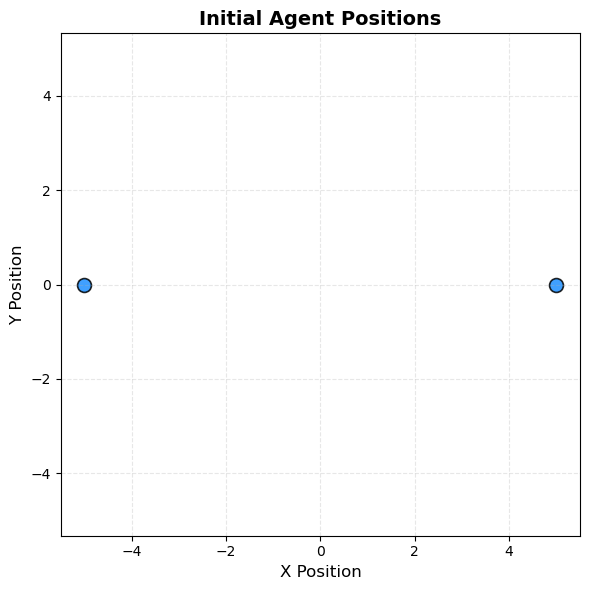

In [420]:
pos=np.zeros((N,2,T))
vel=np.zeros((N,2,T))
acc=np.zeros((N,2,T))
pref_vel=np.zeros((N,2,T)) # in speed, theta coordinets, 1st dim has speed, 2nd dim has angle
v0=np.zeros((N,2,T)) #prefered velocities in x,y coordinates
dists=np.zeros((N,N,T))

t=0
pos[0,0,t]=5
pos[0,1,t]=0
pos[1,0,t]=-5
pos[1,1,t]=0

vel[0,0,t]=0
vel[0,1,t]=0
vel[1,0,t]=0
vel[1,1,t]=0

pref_vel[:,0,:]=s0
pref_vel[0,1,t]=e01
pref_vel[1,0,t]=s0
pref_vel[1,1,t]=e02

# pref_vel[:,0,:]



# pos[2,0,t]=5
# pos[2,1,t]=2.5
# pos[3,0,t]=-5
# pos[3,1,t]=2.5

# R=10
# theta = np.linspace(0, 2*np.pi, N, endpoint=False)-np.pi/4
# pos[:, 0, t] = R * np.cos(theta)  # x
# pos[:, 1, t] = R * np.sin(theta)  # y

plt.figure(figsize=(6, 6))
plt.scatter(
    pos[:, 0, 0], pos[:, 1, 0],
    s=100,                          # Marker size
    c='dodgerblue',                 # Fill color
    edgecolors='k',                 # Edge color
    alpha=0.85,                     # Transparency
    linewidths=1.2                  # Edge line width
)
plt.title("Initial Agent Positions", fontsize=14, weight='bold')
plt.xlabel("X Position", fontsize=12)
plt.ylabel("Y Position", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)
plt.axis('equal')
plt.tight_layout()
plt.show()



## Active Inference Functions

In [421]:
def create_B_matrix(i,t,debugging=False):
  B = np.zeros( (len(states), len(states), len(actions)) )
  pos_temp=np.copy(pos)
  vel_temp=np.copy(vel)
  acc_temp=np.copy(acc)
  pref_vel_temp=np.copy(pref_vel)
  
  
  for action_id, action_label in enumerate(actions):

    # for curr_state, state_label in enumerate(states):
          # if state_label=="DESIRED":
      if action_label=="DEFAULT":
                      
        pref_vel_temp[i,1,t]=pref_vel_temp[i,1,0]
        if debugging:
          print(pref_vel_temp[i,1,0]/np.pi)
        
        
      if action_label=="ML":
        pref_vel_temp[i,1,t]=pref_vel_temp[i,1,t-1]-np.pi/4
        
      if action_label=="MR":
        pref_vel_temp[i,1,t]=pref_vel_temp[i,1,t-1]+np.pi/4
        
      if action_label=="SL":
        pref_vel_temp[i,1,t]=pref_vel_temp[i,1,t-1]-np.pi/2
        
      if action_label=="SR":
        pref_vel_temp[i,1,t]=pref_vel_temp[i,1,t-1]+np.pi/2


      if debugging:     
        print(pref_vel_temp[i,:,t]/np.pi)   
    
      acc_temp[:,:,t]=acc_intrinsic(vel_temp[i,:,t-1],pref_vel_temp[i,0,t],pref_vel_temp[i,1,t])+acc_repulsive(pos_temp,i,t-1)
      

      update_simulation(acc_temp,vel_temp,pos_temp,t,t_iter*dt)
      
      next_state = states.index(get_state_label(acc_intrinsic(vel_temp[i,:,t],pref_vel_temp[i,0,t],pref_vel_temp[i,1,t]),acc_repulsive(pos_temp,i,t)))
      B[next_state, :, action_id] = 1.0
  return B

""" Create an infer states function that implements the math we just discussed"""

def infer_states(observation_index, A, prior):

  """ Implement inference here -- NOTE: prior is already passed in, so you don't need to do anything with the B matrix. """
  """ This function has already been given P(s_t). The conditional expectation that creates "today's prior", using "yesterday's posterior", will happen *before calling* this function"""
  
  log_likelihood = log_stable(A[observation_index,:])

  log_prior = log_stable(prior)

  qs = softmax(log_likelihood + log_prior)
   
  return qs


""" define component functions for computing expected free energy """

def get_expected_states(B, qs_current, action):
  """ Compute the expected states one step into the future, given a particular action """
  qs_u = B[:,:,action].dot(qs_current)

  return qs_u

def get_expected_observations(A, qs_u):
  """ Compute the expected observations one step into the future, given a particular action """

  qo_u = A.dot(qs_u)

  return qo_u

def entropy(A):
  """ Compute the entropy of a set of conditional distributions, i.e. one entropy value per column """

  H_A = - (A * log_stable(A)).sum(axis=0)

  return H_A

def kl_divergence(qo_u, C):
  """ Compute the Kullback-Leibler divergence between two 1-D categorical distributions"""
  
  return (log_stable(qo_u) - log_stable(C)).dot(qo_u)

def calculate_G(A, B, C, qs_current, actions):

  G = np.zeros(len(actions)) # vector of expected free energies, one per action

  H_A = entropy(A) # entropy of the observation model, P(o|s)

  for action_i in range(len(actions)):
    
    qs_u = get_expected_states(B, qs_current, action_i) # expected states, under the action we're currently looping over
    qo_u = get_expected_observations(A, qs_u)           # expected observations, under the action we're currently looping over

    pred_uncertainty = H_A.dot(qs_u) # predicted uncertainty, i.e. expected entropy of the A matrix
    pred_div = kl_divergence(qo_u, C) # predicted divergence

    G[action_i] = pred_uncertainty + pred_div # sum them together to get expected free energy
  
  return G



              

## Simulation functions

In [422]:
def acc_intrinsic(vel,pref_speed,pref_dir):
    v0=pref_speed*np.round(np.array([np.cos(pref_dir),np.sin(pref_dir)]),2)
    return -alph*(vel-v0)

def acc_repulsive(pos,i,t):
    repulsion_term=0
    for j in range(N):
        dists[i,j,t]=np.sqrt(eps+(pos[i,0,t]-pos[j,0,t])**2+(pos[i,1,t]-pos[j,1,t])**2)
        if dists[i,j,t]>ROI:
            continue
        else:
            repulsion_term+= gam*(pos[i,:,t]-pos[j,:,t])/((dists[i,j,t]-Dia)**3) 
    return repulsion_term

def get_state_label(intrinsic_term,repulsion_term, debugging=False):
    d=(np.linalg.norm(repulsion_term)/(eps+np.linalg.norm(intrinsic_term))).round(1)
    if debugging:
        print(d)
    
    if "MILD" in states:
      state_label="DESIRED" if (d <=desired_up) else "MILD" if (d>desired_up and d<mild_up) else "SIGNIFICANT"
    else:
      state_label="DESIRED" if (d <=desired_up) else "SIGNIFICANT"
      
    return state_label

def update_simulation(acc,vel,pos,t,dt=dt):
    if single_agent:
        vel[0,:,t]=vel[0,:,t-1]+(dt*acc[0,:,t])
    else:
        vel[:,:,t]=vel[:,:,t-1]+(dt*acc[:,:,t])
    
    pos[:, :, t] = ((pos[:, :, t-1] + dt * vel[:, :, t] + S) % (2 * S)) - S


def action_to_pref_vel(chosen_action,i,t,debugging=False):
  action_label=actions[chosen_action]
  if debugging: 
    print(action_label)
  if action_label=="DEFAULT":
                      
    pref_vel[i,1,t]=pref_vel[i,1,0]

  if action_label=="ML":
    pref_vel[i,1,t]=pref_vel[i,1,t-1]-np.pi/4

  if action_label=="MR":
    pref_vel[i,1,t]=pref_vel[i,1,t-1]+np.pi/4

  if action_label=="SL":
    pref_vel[i,1,t]=pref_vel[i,1,t-1]-np.pi/2

  if action_label=="SR":
    pref_vel[i,1,t]=pref_vel[i,1,t-1]+np.pi/2
  if debugging:
    print(pref_vel[i,1,t]/np.pi)

# def polar_to_cartesian(v)

## Simulation Loop

In [423]:
n_states = len(states)
n_observations = len(states)
for t in range(1,T):
    print(f"==========================Time {t}=================================")
    for i in range(N):
        print(f"-----------Agent {i}---------------")
        # Active Inferencing
        curr_state=get_state_label(acc_intrinsic(vel[i,:,t-1],pref_vel[i,0,t-1],pref_vel[i,1,t-1]),acc_repulsive(pos,i,t-1))

        A = np.eye(n_observations, n_states)
        B = create_B_matrix(i,t)
        C = utils.onehot(states.index("DESIRED"),n_states)
        D = utils.onehot(states.index(curr_state), n_states)
        prior = D.copy() #if t==1 else B[:,:,chosen_action].dot(qs_current) 
        obs=curr_state
        # if obs=="DESIRED":
        #     isactinfing=0
        # else:
        #     isactinfing=isactinfinggrand
        
        # isactinfingisactinfinggrand
            
        
        obs_idx=states.index(obs)
        
            # perform inference over hidden states
        qs_current = infer_states(obs_idx, A, prior)
        
        G = calculate_G(A, B, C, qs_current, actions)
        Q_u = softmax(-G)
        
        if t>Ta:
            # chosen_action=utils.sample(Q_u)  
            chosen_action=np.argmax(Q_u)  #Picking the Max, instead of sampling
        
        else:
            chosen_action=0
        
        # print(f'Observes itself in: {obs}')
        # print("Probability of Actions:",Q_u) 
        # print("Inferred Consequences: ",[states[np.argmax(B[:,np.argmax(qs_current),i])] for i in range(len(actions))])
        # print(f"chosen_action={actions[chosen_action]}")
        
        
        for agent_id in agents_log:
            # Folowing code is just a more visual version of up commented 4 lines
            print(f"Observed State: {obs}")

            print("\nProbability of Actions:")
            for action, prob in zip(actions, Q_u):
                print(f"  - {action:<10}: {prob:.3f}")

            print("\nInferred Consequences:")
            for p, action in enumerate(actions):
                inferred = states[np.argmax(B[:, np.argmax(qs_current), p])]
                print(f"  - If '{action}' then → '{inferred}'")

            print(f"\nChosen Action: {actions[chosen_action]}")

        
        
        # pref_vel[:,:,t]=pref_vel[:,:,t-1] #should come from active inference
        
        action_to_pref_vel(chosen_action,i,t) #updates preferred velocity
        acc[i,:,t]=acc_intrinsic(vel[i,:,t-1],pref_vel[i,0,t],pref_vel[i,1,t])+acc_repulsive(pos,i,t-1)  #if i!=1 else acc[i,:,t-1]
    
    update_simulation(acc,vel,pos,t)
    

==========================Time 1=================================
-----------Agent 0---------------
Observed State: DESIRED

Probability of Actions:
  - DEFAULT   : 0.200
  - ML        : 0.200
  - MR        : 0.200
  - SL        : 0.200
  - SR        : 0.200

Inferred Consequences:
  - If 'DEFAULT' then → 'DESIRED'
  - If 'ML' then → 'DESIRED'
  - If 'MR' then → 'DESIRED'
  - If 'SL' then → 'DESIRED'
  - If 'SR' then → 'DESIRED'

Chosen Action: DEFAULT
-----------Agent 1---------------
Observed State: DESIRED

Probability of Actions:
  - DEFAULT   : 0.200
  - ML        : 0.200
  - MR        : 0.200
  - SL        : 0.200
  - SR        : 0.200

Inferred Consequences:
  - If 'DEFAULT' then → 'DESIRED'
  - If 'ML' then → 'DESIRED'
  - If 'MR' then → 'DESIRED'
  - If 'SL' then → 'DESIRED'
  - If 'SR' then → 'DESIRED'

Chosen Action: DEFAULT
==========================Time 2=================================
-----------Agent 0---------------
Observed State: DESIRED

Probability of Actions:
  -

## Plots

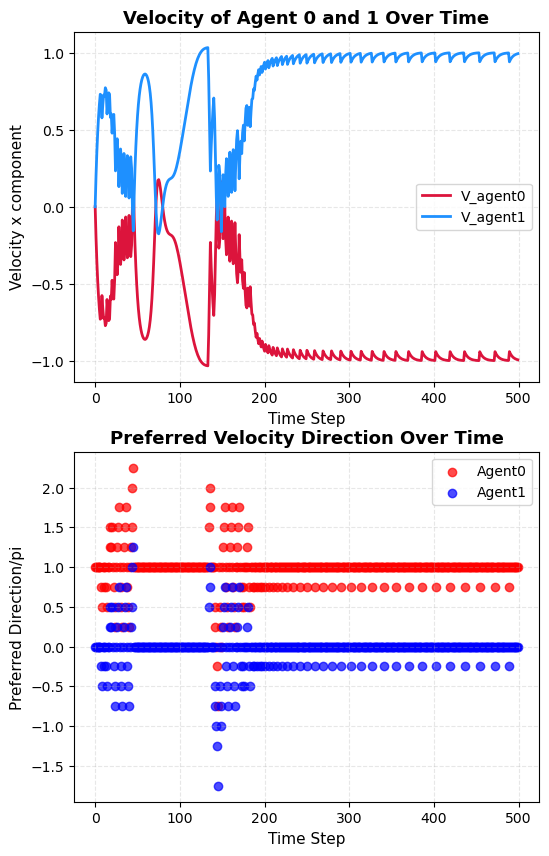

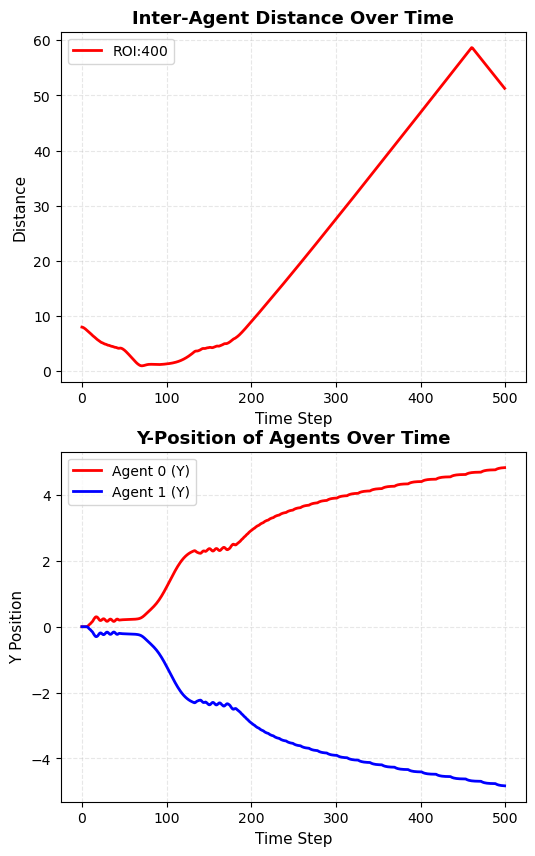

In [427]:
Tp=500



# Got the plotting codes from chatGPT
# === Plotting Velocity and Interagent Distance (Portrait Layout) ===
plt.figure(figsize=(6, 10))  # Taller figure for portrait

# --- Top Tile: Velocity of Agent 1 ---
plt.subplot(2, 1, 1)
plt.plot(
    [vel[0, 0, t] for t in range(Tp)],
    color='crimson', label='V_agent0', linewidth=2
)
plt.plot(
    [vel[1, 0, t] for t in range(Tp)],
    color='dodgerblue', label='V_agent1', linewidth=2
)
plt.title("Velocity of Agent 0 and 1 Over Time", fontsize=13, weight='bold')
plt.xlabel("Time Step", fontsize=11)
plt.ylabel("Velocity x component", fontsize=11)
plt.legend(frameon=True)
plt.grid(True, linestyle='--', alpha=0.3)


plt.subplot(2, 1, 2)
plt.scatter(
    range(Tp),
    [(pref_vel[0, 1, t]/np.pi).round(2) for t in range(Tp)],
    color='red', label='Agent0', alpha=0.7
)
plt.scatter(
    range(Tp),
    [(pref_vel[1, 1, t]/np.pi).round(2) for t in range(Tp)],
    color='blue', label='Agent1', alpha=0.7
)
plt.title("Preferred Velocity Direction Over Time", fontsize=13, weight='bold')
plt.xlabel("Time Step", fontsize=11)
plt.ylabel("Preferred Direction/pi", fontsize=11)
plt.legend(frameon=True)
plt.grid(True, linestyle='--', alpha=0.3)




# === Plotting Preferred Velocity (Portrait Layout) ===
plt.figure(figsize=(6, 10))  # Taller figure for portrait

# --- Top Tile: Preferred Velocity X Component ---
plt.subplot(2, 1, 1)
plt.plot(
    [dists[1, 0, t]-Dia for t in range(Tp)],
    color='red', label=f'ROI:{ROI}', linewidth=2
)
# plt.plot(
#     [pref_vel[1, 0, t] for t in range(T)],
#     color='blue', label='agent1 -->', linewidth=2
# )
plt.title("Inter-Agent Distance Over Time", fontsize=13, weight='bold')
plt.xlabel("Time Step", fontsize=11)
plt.ylabel("Distance", fontsize=11)
plt.legend(frameon=True)
plt.grid(True, linestyle='--', alpha=0.3)



# --- Bottom Tile: Interagent Distance (Agent 0 and 1) ---
plt.subplot(2, 1, 2)

# Plot y-position over time for Agent 0
plt.plot(
    [pos[0, 1, t] for t in range(Tp)],
    color='red', label='Agent 0 (Y)', linewidth=2
)

# Plot y-position over time for Agent 1
plt.plot(
    [pos[1, 1, t] for t in range(Tp)],
    color='blue', label='Agent 1 (Y)', linewidth=2
)

plt.title("Y-Position of Agents Over Time", fontsize=13, weight='bold')
plt.xlabel("Time Step", fontsize=11)
plt.ylabel("Y Position", fontsize=11)
plt.legend(frameon=True)
plt.grid(True, linestyle='--', alpha=0.3)





## Saving Video

In [425]:
if wanna_save:
    fig, ax = plt.subplots(figsize=(10, 10))

    # Initial scatter with dummy positions and fixed colors
    scat = ax.scatter([0, 0], [0, 0], s=360*Dia, c=['red', 'blue'], edgecolors='k', alpha=0.85)
    title = ax.text(0.5, 1.05, '', transform=ax.transAxes, ha='center', fontsize=14)

    # Legend handles
    red_patch = mpatches.Patch(color='red', label='<--')
    blue_patch = mpatches.Patch(color='blue', label='-->')
    ax.legend(handles=[red_patch, blue_patch], loc='upper right')

    def init():
        ax.set_xlim(-S, S)
        ax.set_ylim(-S, S)
        ax.set_xlabel("x", fontsize=12)
        ax.set_ylabel("y", fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.5)
        ax.set_aspect("equal")
        return scat, title

    def update(t):
        scat.set_offsets(pos[:, :, t])
        title.set_text(f"N={N}, t={t}/{T}, dt={dt}, \n isactinfing={isactinfinggrand} | isplanning={isplanning} | Actinfagents={1-single_agent+1} \n alph={alph},ROI={ROI},Dia={Dia},Gamma={gam} \n t_iter={t_iter}")
        return scat, title

    ani = FuncAnimation(fig, update, frames=T, init_func=init, blit=True, interval=50)

    writer = FFMpegWriter(fps=20, metadata=dict(artist='Active Inference'))
    ani.save("agent_positions.mp4", writer=writer)
    plt.close()

    print("✅ Video saved as 'agent_positions.mp4'")
